### 0. Notebook setup

In [2]:
COLAB = False # Set this to True if you want to install the libraries and clone the repository in Colab
USE_DOTENV = True # Set this to False if you don't have a .env file for storing environment variables
if COLAB:
    USE_DOTENV = False
    dotenv_path = None
    from google.colab import userdata
    colab_secrets = {'HF_TOKEN': userdata.get('HF_TOKEN'), 'HF_TOKEN_WRITE': userdata.get('HF_TOKEN_WRITE')}
    !pip install datasets langdetect
    !git clone https://github.com/reddgr/chatbot-response-scoring-scbn-rqtl
    import os
    os.system("mv chatbot-response-scoring-scbn-rqtl scbn_rqtl") ### Change repo name when public

In [3]:
if USE_DOTENV: 
    COLAB=False
    dotenv_path = "../../../../../apis/.env"
    colab_secrets = None

from transformers import pipeline, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf
import random
from datasets import load_dataset, Dataset
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import sys
import os
import torch
import textwrap
from IPython.display import clear_output
import matplotlib.pyplot as plt


if COLAB:
    from scbn_rqtl import env_options, nli_labeling_widget, text_classification_functions as tcf, lmsys_dataset_handler as lmsys
else:
    import sys
    sys.path.append("./src")
    import text_classification_functions as tcf
    import env_options
    import lmsys_dataset_handler as lmsys
    import nli_finetuning_utils

hf_token, hf_token_write, openai_api_key = env_options.check_env(colab=COLAB, use_dotenv=USE_DOTENV, 
                                                 dotenv_path=dotenv_path, colab_secrets=colab_secrets)


Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.2.2
Transformers version: 4.44.2
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Version: 12.1
FlashAttention available: True
Retrieved token(s) from .env file
Using HuggingFace token: hf_M*****************************IASJ
Using HuggingFace write token: hf_u*****************************Xipx
Using OpenAI token: sk-p************************************************************************************************************************************************************_5sA


In [16]:
### DEBUG ###
import importlib
importlib.reload(nli_finetuning_utils)
### DEBUG ###

<module 'nli_finetuning_utils' from 'c:\\Users\\david\\Documents\\python_scripts\\nli_finetuning\\./src\\nli_finetuning_utils.py'>

## Preparing test datasets

Loading the Test dataset

In [4]:
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
print("Labels: ",test_dataset_dict["test"].features["label"]._str2int)
entailments_test_dataset_df = test_dataset_df[test_dataset_df['label'] == 2]
display(entailments_test_dataset_df.head(3))
print(f'... {len(entailments_test_dataset_df)} records ...')
display(entailments_test_dataset_df.tail(3))

Labels:  {'contradiction': 0, 'neutral': 1, 'entailment': 2}


,text,category,label
5,I wanna have a conversation in german to practice,language,2
7,What you think about Belarus?,general knowledge,2
9,What does LLaMA means?,technology,2


... 204 records ...


,text,category,label
351,"This is another headline:\n\n""Existentialism a...",writing,2
355,how many companies are included in each of tho...,business,2
357,What is the smallest integer whose square is b...,riddle,2


### Define category lists for test metrics

10 categories:

In [5]:
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_filter = 10
print(f'Top {top_n_filter} prompt categories (Test split):\n{category_counts.head(top_n_filter)}')
# We exclude "general knowledge" from the tests given the high ambiguity of the category
category_counts = category_counts[category_counts.index != 'general knowledge']
top_categories = category_counts.head(top_n_filter).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
print(f'{len(test_entailments_df)} records for testing {top_n_filter} categories')
test_entailments_dataset = Dataset.from_pandas(test_entailments_df)
print(test_entailments_dataset)
print(top_categories.to_list())

Top 10 prompt categories (Test split):
category
coding               29
technology           29
language             26
science              22
writing              19
business             14
popular culture      11
riddle                9
role play             9
general knowledge     8
Name: count, dtype: int64
175 records for testing 10 categories
Dataset({
    features: ['text', 'category', 'label', '__index_level_0__'],
    num_rows: 175
})
['coding', 'technology', 'language', 'science', 'writing', 'business', 'popular culture', 'riddle', 'role play', 'ai']


Grouped categories:

In [6]:
test_df_grouped = entailments_test_dataset_df.copy()
test_df_grouped.loc[test_df_grouped['category'] == 'business', 'category'] = 'business and finance'
test_df_grouped.loc[test_df_grouped['category'] == 'finance', 'category'] = 'business and finance'
test_df_grouped.loc[test_df_grouped['category'] == 'language', 'category'] = 'language and writing'
test_df_grouped.loc[test_df_grouped['category'] == 'writing', 'category'] = 'language and writing'
test_df_grouped.loc[test_df_grouped['category'] == 'popular culture', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'music', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'entertainment', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'technology', 'category'] = 'technology and ai'
test_df_grouped.loc[test_df_grouped['category'] == 'ai', 'category'] = 'technology and ai'
category_counts = test_df_grouped['category'].value_counts()
top_n_display = 10
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 6
top_grouped_categories = category_counts.head(top_n_categories).index
test_entailments_grouped = test_df_grouped[test_df_grouped['category'].isin(top_grouped_categories)]
print(f'{len(test_entailments_grouped)} records for testing {top_n_categories} category groups')
print(top_grouped_categories.to_list())

Top 10 prompt categories:
category
language and writing         45
technology and ai            36
coding                       29
science                      22
business and finance         19
culture and entertainment    13
riddle                        9
role play                     9
general knowledge             8
philosophy                    4
Name: count, dtype: int64
164 records for testing 6 category groups
['language and writing', 'technology and ai', 'coding', 'science', 'business and finance', 'culture and entertainment']


## Tests metrics for current model

No need to run these cells if there's no new version of the model

### 10-category test (current model)

Zero-shot classification on test data::   0%|          | 0/175 [00:00<?, ?it/s]c:\Users\david\anaconda3\Lib\site-packages\transformers\models\bart\modeling_bart.py:496: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Zero-shot classification on test data:: 100%|██████████| 175/175 [00:35<00:00,  4.87it/s]


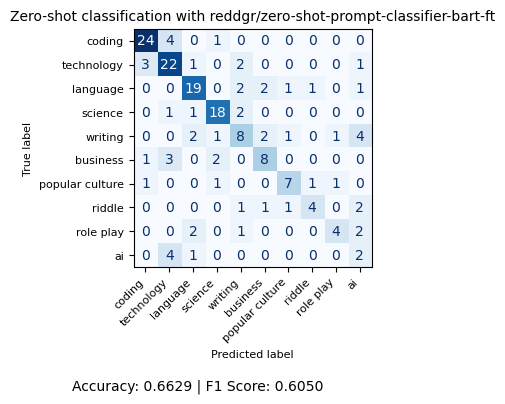

In [6]:
nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier_10 = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
zs_test_metrics = zs_classifier_10.test_zs_predictions(test_entailments_df)

### 6 grouped categories test (current model)

Zero-shot classification on test data:: 100%|██████████| 164/164 [00:18<00:00,  8.77it/s]


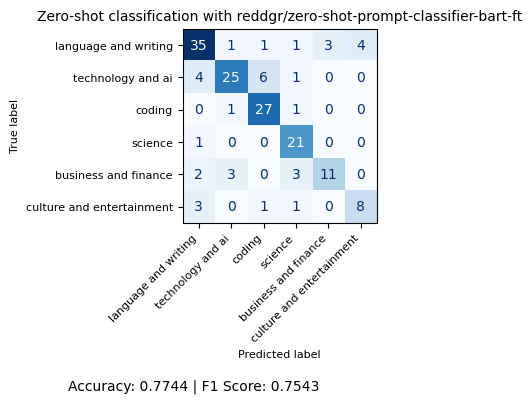

In [7]:
nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier_grouped = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_grouped_categories)
zs_test_metrics_grouped = zs_classifier_grouped.test_zs_predictions(test_entailments_grouped)

## Finetuning

Loading the Train split:

In [7]:
SAMPLING = True
dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
hf_dataset = dataset_dict["train"]

if SAMPLING:
    n_samples = 100
    # SAMPLING ONLY LATEST n_samples RECORDS
    total_samples = len(hf_dataset)
    hf_dataset = dataset_dict["train"].select(range(total_samples - n_samples, total_samples))

hf_dataset = hf_dataset.rename_column('category', 'class')

hf_dataset_df = hf_dataset.to_pandas()
print("Labels: ",dataset_dict["train"].features["label"]._str2int)

display(hf_dataset_df.head(3))
print(f'... {len(hf_dataset_df)} records ...')
display(hf_dataset_df.tail(3))

Labels:  {'contradiction': 0, 'neutral': 1, 'entailment': 2}


,text,class,label
0,"OK, thanks. Let's extract the dataframes with ...",coding,2
1,"OK, thanks. Let's extract the dataframes with ...",images,0
2,"You don’t understand the meme, the joke is abo...",riddle,1


... 100 records ...


,text,class,label
97,This is a screenshot from ChatGPT. The Meme Er...,technology,1
98,This is a screenshot from ChatGPT. The Meme Er...,science,0
99,This is a screenshot from ChatGPT. The Meme Er...,images,2


Tokenizing and formatting the dataset:

In [8]:
nli_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli', clean_up_tokenization_spaces=True)
nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli', clean_up_tokenization_spaces=True)
print(f"Loaded NLI model with head:\n{nli_model.classification_head.out_proj}\n{nli_model.config.id2label}")

Loaded NLI model with head:
Linear(in_features=1024, out_features=3, bias=True)
{0: 'contradiction', 1: 'neutral', 2: 'entailment'}


In [9]:
template = "This example is a {} prompt."
max_length = 128
eval_proportion = 0.2

tokenize_and_format_nli_dataset

In [10]:
# Convert the dataset to a Pandas DataFrame
df = hf_dataset.to_pandas()

input_ids, attention_masks, labels, input_sentences = [], [], [], []

for index, row in df.iterrows():
    text = row["text"]
    category = row["class"] 
    label = row["label"]

    # Construct text with template
    nli_text = f"<prompt>{text}</prompt> {template.format(category)}"
    input_sentences.append(nli_text)

    # Tokenize example
    encoding = nli_tokenizer(
        nli_text,
        max_length=max_length - 1,  # Leave space for <eos> token
        padding="max_length", 
        truncation=True,
        return_tensors="pt",
        add_special_tokens=True,
    )

    input_ids.append(encoding["input_ids"].squeeze(0))
    attention_masks.append(encoding["attention_mask"].squeeze(0))
    labels.append(label)

# Create tokenized dataset
full_dataset = Dataset.from_dict({
    "input_ids": [seq.tolist() for seq in input_ids],
    "attention_mask": [mask.tolist() for mask in attention_masks],
    "labels": labels,
    "input_sentence": input_sentences,
})

# Split dataset
shuffled_dataset = full_dataset.shuffle(seed=42)
split_index = int(len(shuffled_dataset) * (1 - eval_proportion))

train_dataset = shuffled_dataset.select(range(split_index))
eval_dataset = shuffled_dataset.select(range(split_index, len(shuffled_dataset)))

In [11]:
print(f"Train dataset: {len(train_dataset)}, Eval dataset: {len(eval_dataset)}")
print(top_grouped_categories)
print("\nInput sentence example:")
random_index = random.randint(0, len(train_dataset))
print(train_dataset.to_pandas()['input_sentence'].iloc[random_index])
print(f"Label: {train_dataset.to_pandas()['labels'].iloc[random_index]}", 
      f"({dataset_dict['train'].features['label']._int2str[train_dataset.to_pandas()['labels'].iloc[random_index]]})")

Train dataset: 80, Eval dataset: 20
Index(['language and writing', 'technology and ai', 'coding', 'science',
       'business and finance', 'culture and entertainment'],
      dtype='object', name='category')

Input sentence example:
<prompt>Give me an example of an R tidyverse code for counting the number of words and sentences of a text. </prompt> This example is a images prompt.
Label: 0 (contradiction)


In [12]:
model = AutoModelForSequenceClassification.from_pretrained('reddgr/zero-shot-prompt-classifier-bart-ft', clean_up_tokenization_spaces=True)
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli', clean_up_tokenization_spaces=True)
print("model_type: ",model.config.model_type)
print("model_input_names: ",tokenizer.model_input_names)
print("num_labels: ",model.config.num_labels)
print("max_position_embeddings: ",getattr(model.config, "max_position_embeddings", None))

model_type:  bart
model_input_names:  ['input_ids', 'attention_mask']
num_labels:  3
max_position_embeddings:  1024


In [13]:
learning_rate=1e-5 # 1 e-5 # 5e-6
n_epochs=2
bsize=32 # 32 if you have the memory
t_max=8 ### 10
base_learning_rate = learning_rate
output_dir = "./models"
epochs = n_epochs
batch_size = bsize
# trainer, train_results = fine_tuner.fine_tune_with_cosine_annealing("./models", n_epochs, bsize, learning_rate, t_max)

fine_tune_with_cosine_annealing

In [14]:
from transformers import Trainer, TrainingArguments, TrainerCallback, TrainerState, TrainerControl
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch import cuda

In [36]:
class CustomTrainer(Trainer):
    def _maybe_log_save_evaluate(self, tr_loss, model, trial, epoch, ignore_keys_for_eval, start_time):
        """Modified to log train_loss at the end of each epoch."""
        if self.control.should_log:
            logs = {}
            tr_loss_scalar = tr_loss.item()
            effective_global_step = max(self.state.global_step, 0.001)
            train_loss = float(self._total_loss_scalar) / float(effective_global_step) if effective_global_step > 0 else 0.0

            ignore_keys_for_eval = [] if ignore_keys_for_eval is None else list(ignore_keys_for_eval)
            metrics = self.evaluate(ignore_keys=ignore_keys_for_eval)
            logs.update({k: v for k, v in metrics.items() if isinstance(v, (int, float, list))})
            ignore_keys_for_eval = list(ignore_keys_for_eval) if isinstance(ignore_keys_for_eval, tuple) else ignore_keys_for_eval
            self.log(logs)

        if self.control.should_save:
            self._save_checkpoint(model, trial, metrics)
            self.control.should_save = False

        if self.control.should_evaluate:
            self.evaluate(ignore_keys=ignore_keys_for_eval)
            self.control.should_evaluate = False


In [37]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model = model.to(device)

# Prepare dataset
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=base_learning_rate)

# Set up cosine annealing scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=t_max)

# Custom training loop
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    save_steps=10,
    save_total_limit=2,
    logging_dir=f"{output_dir}/logs",
    eval_strategy="epoch"
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    optimizers=(optimizer, scheduler),  # Pass both optimizer and scheduler
)

print("Fine-tuning in progress...")
train_results = trainer.train()
print(f"Fine-tuning complete. Model saved to {output_dir}.")

print(f"Last checkpoint {trainer.state.global_step}")

Using device: cuda:0
Fine-tuning in progress...


  0%|          | 0/6 [00:00<?, ?it/s]

TypeError: unsupported operand type(s) for +: 'int' and 'list'

In [19]:
for obj in trainer.state.log_history:
    print(obj)

{'eval_loss': 0.6071503758430481, 'eval_runtime': 3.2952, 'eval_samples_per_second': 6.069, 'eval_steps_per_second': 0.91, 'epoch': 1.0, 'step': 3}
{'eval_loss': 0.6218997240066528, 'eval_runtime': 4.8304, 'eval_samples_per_second': 4.14, 'eval_steps_per_second': 0.621, 'epoch': 2.0, 'step': 6}
{'train_runtime': 126.5591, 'train_samples_per_second': 1.264, 'train_steps_per_second': 0.047, 'total_flos': 43131824084160.0, 'train_loss': 0.6819352308909098, 'epoch': 2.0, 'step': 6}


In [18]:
for obj in trainer.state.log_history:
    print(obj)
metrics = train_results.metrics
print(f"Train metrics: {metrics}")
print(trainer.state.global_step)

{'eval_loss': 0.6071503758430481, 'eval_runtime': 3.2952, 'eval_samples_per_second': 6.069, 'eval_steps_per_second': 0.91, 'epoch': 1.0, 'step': 3}
{'eval_loss': 0.6218997240066528, 'eval_runtime': 4.8304, 'eval_samples_per_second': 4.14, 'eval_steps_per_second': 0.621, 'epoch': 2.0, 'step': 6}
{'train_runtime': 126.5591, 'train_samples_per_second': 1.264, 'train_steps_per_second': 0.047, 'total_flos': 43131824084160.0, 'train_loss': 0.6819352308909098, 'epoch': 2.0, 'step': 6}
Train metrics: {'train_runtime': 126.5591, 'train_samples_per_second': 1.264, 'train_steps_per_second': 0.047, 'total_flos': 43131824084160.0, 'train_loss': 0.6819352308909098, 'epoch': 2.0}
6


#### Fine-tuning:

Loading model and tokenizer:

In [22]:
# model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli', clean_up_tokenization_spaces=True)
model = AutoModelForSequenceClassification.from_pretrained('reddgr/zero-shot-prompt-classifier-bart-ft', clean_up_tokenization_spaces=True)
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli', clean_up_tokenization_spaces=True)
print("model_type: ",model.config.model_type)
print("model_input_names: ",tokenizer.model_input_names)
print("num_labels: ",model.config.num_labels)
print("max_position_embeddings: ",getattr(model.config, "max_position_embeddings", None))

model_type:  bart
model_input_names:  ['input_ids', 'attention_mask']
num_labels:  3
max_position_embeddings:  1024


In [23]:
learning_rate=1e-5 # 1 e-5 # 5e-6
n_epochs=2
bsize=32 # 32 if you have the memory
t_max=8 ### 10
# trainer = fine_tuner.fine_tune(output_dir="./models", epochs=n_epochs, batch_size=bsize, learning_rate=learning_rate)
trainer, train_results = fine_tuner.fine_tune_with_cosine_annealing("./models", n_epochs, bsize, learning_rate, t_max)

Using device: cuda:0
Fine-tuning in progress...


  0%|          | 0/6 [00:00<?, ?it/s]

Last learning rate: 1e-05

Epoch 1.0 complete.


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.966015636920929, 'eval_runtime': 4.6306, 'eval_samples_per_second': 4.319, 'eval_steps_per_second': 0.648, 'epoch': 1.0}
Last learning rate: 6.913417161825449e-06


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}



Epoch 2.0 complete.


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.7792290449142456, 'eval_runtime': 3.7069, 'eval_samples_per_second': 5.395, 'eval_steps_per_second': 0.809, 'epoch': 2.0}
{'train_runtime': 127.5133, 'train_samples_per_second': 1.255, 'train_steps_per_second': 0.047, 'train_loss': 0.8734267552693685, 'epoch': 2.0}
Fine-tuning complete. Model saved to ./models.
Last checkpoint 6


In [13]:
for obj in trainer.state.log_history:
    print(obj)
metrics = train_results.metrics
print(f"Train metrics: {metrics}")
print(trainer.state.global_step)

{'eval_loss': 0.8445579409599304, 'eval_runtime': 18.6182, 'eval_samples_per_second': 12.676, 'eval_steps_per_second': 1.611, 'epoch': 1.0, 'step': 59}
{'eval_loss': 0.8014081716537476, 'eval_runtime': 15.0327, 'eval_samples_per_second': 15.699, 'eval_steps_per_second': 1.996, 'epoch': 2.0, 'step': 118}
{'eval_loss': 0.7652978301048279, 'eval_runtime': 22.1859, 'eval_samples_per_second': 10.637, 'eval_steps_per_second': 1.352, 'epoch': 3.0, 'step': 177}
{'eval_loss': 0.7995297312736511, 'eval_runtime': 19.5463, 'eval_samples_per_second': 12.074, 'eval_steps_per_second': 1.535, 'epoch': 4.0, 'step': 236}
{'train_runtime': 2486.7576, 'train_samples_per_second': 1.514, 'train_steps_per_second': 0.095, 'total_flos': 1014676161579864.0, 'train_loss': 0.7561844001382084, 'epoch': 4.0, 'step': 236}
Train metrics: {'train_runtime': 2486.7576, 'train_samples_per_second': 1.514, 'train_steps_per_second': 0.095, 'total_flos': 1014676161579864.0, 'train_loss': 0.7561844001382084, 'epoch': 4.0}
236

In [14]:
checkpoint_step = trainer.state.global_step
print(f"Last checkpoint step: {checkpoint_step}")

Last checkpoint step: 236


MANUAL SAVE:

Save the model (if not saved already):

In [15]:
output_dir = "./models/checkpoint-last"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to: {output_dir}")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


Model and tokenizer saved to: ./models/checkpoint-last


LOAD LAST STEP:

In [15]:
# checkpoint_step = 81
checkpoint_step = trainer.state.global_step
# checkpoint_step = 'last'
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(f"./models/checkpoint-{checkpoint_step}")
print(f"Loaded model from: ./models/checkpoint-{checkpoint_step}")

Loaded model from: ./models/checkpoint-236


### Grouped categories test

sequence: What is the smallest integer whose square is between 15 and 30?
labels: ['science', 'business and finance', 'coding', 'technology and ai', 'culture and entertainment', 'language and writing']
scores: [0.477, 0.149, 0.136, 0.123, 0.079, 0.036]


Zero-shot classification on test data:: 100%|██████████| 164/164 [02:13<00:00,  1.23it/s]


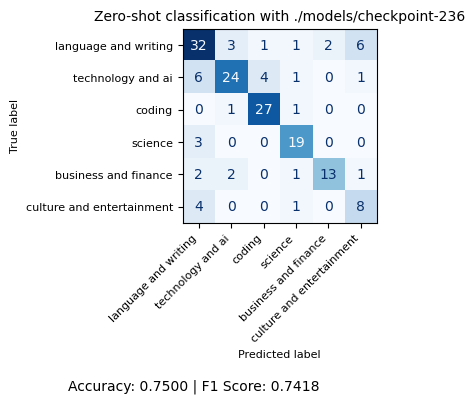

In [16]:
finetuned_model_path=f"./models/checkpoint-{checkpoint_step}"
tokenizer_path="facebook/bart-large-mnli"
# zs_classifier_finetuned = tcf.ZeroShotClassifier(finetuned_model_path, tokenizer_path, top_categories)
zs_classifier_finetuned = tcf.ZeroShotClassifier(finetuned_model_path, tokenizer_path, top_grouped_categories)
text_sample = test_entailments_df.sample(1, random_state=38).text.values[0]
result = zs_classifier_finetuned.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
for key, value in result.items():
    print(f"{key}: {value}")

zs_test_metrics_ft_grouped = zs_classifier_finetuned.test_zs_predictions(test_entailments_grouped)

### 10-category test

c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Zero-shot classification on test data:: 100%|██████████| 175/175 [06:35<00:00,  2.26s/it]


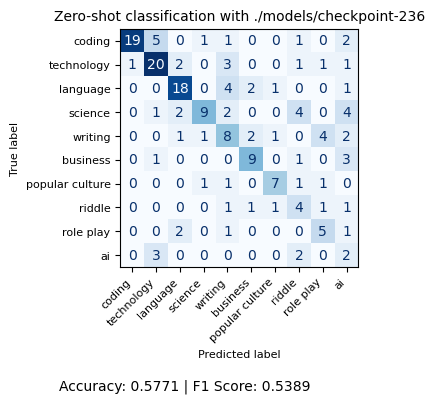

In [17]:
zs_classifier_finetuned = tcf.ZeroShotClassifier(finetuned_model_path, tokenizer_path, top_categories)
zs_test_metrics_ft = zs_classifier_finetuned.test_zs_predictions(test_entailments_df)

### Other tests

In [41]:
base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)

nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier_finetuned = tcf.ZeroShotClassifier(finetuned_model_path, base_model_path, top_categories)

# text_sample = test_entailments_df.sample(1).text.values[0]
text_sample = "I'm twice the age you were when i was your age. How old are we?"
ft_result = zs_classifier_finetuned.classify_text(text_sample, multi_label=False)
base_result = base_classifier.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
print("Classification with fine-tuned model:")
for key, value in ft_result.items():
    print(f"{key}: {value}")

print("Classification with base model:")
for key, value in base_result.items():
    print(f"{key}: {value}")

Classification with fine-tuned model:
sequence: I'm twice the age you were when i was your age. How old are we?
labels: ['ai', 'riddle', 'role play', 'popular culture', 'language', 'writing', 'business', 'science', 'technology', 'coding']
scores: [0.26, 0.19, 0.126, 0.079, 0.078, 0.078, 0.068, 0.05, 0.045, 0.025]
Classification with base model:
sequence: I'm twice the age you were when i was your age. How old are we?
labels: ['riddle', 'ai', 'language', 'role play', 'writing', 'popular culture', 'science', 'business', 'technology', 'coding']
scores: [0.348, 0.342, 0.08, 0.051, 0.049, 0.035, 0.027, 0.026, 0.024, 0.018]


Further checks on Test data:

In [16]:
zs_test_metrics_ft.get('detailed_results')
results_df = pd.DataFrame(zs_test_metrics_ft['detailed_results'])
results_by_category = results_df.groupby(['category', 'predicted_class']).size().unstack(fill_value=0)
accuracy_by_category = results_df.groupby('category').apply(lambda x: (x['category'] == x['predicted_class']).mean())

print("\nAccuracy by category:")
for category in top_categories:
    print(f"{category:20} {accuracy_by_category[category]:.3f}")

print("\nResults sample:")
display(results_df.sample(5))



Accuracy by category:
technology           0.500
language             0.565
coding               0.846
science              0.364
business             0.846
writing              0.611
popular culture      0.545
role play            0.556
riddle               0.500
general knowledge    0.250

Results sample:


,text,category,label,predicted_class
175,Extract attributes from the product title: NAM...,business,2,business
248,Hi there! I wanna you to assist me in composin...,technology,2,coding
130,Could you give me the bibtex of this paper?,science,2,writing
97,The only book I have read by Stanislaw Lem is ...,popular culture,2,writing
170,Please write a Python function with comments t...,coding,2,coding


#### Push to hub:

In [20]:
fine_tuner.model.push_to_hub("reddgr/zero-shot-prompt-classifier-bart-ft", token=hf_token_write)
fine_tuner.tokenizer.push_to_hub("reddgr/zero-shot-prompt-classifier-bart-ft", token=hf_token_write)

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

c:\Users\david\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\david\.cache\huggingface\hub\models--reddgr--zero-shot-prompt-classifier-bart-ft. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some non-default generation parameters are set in the model config. These should go into a Genera

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/reddgr/zero-shot-prompt-classifier-bart-ft/commit/f87341898a2861448dac82257f708419d6294322', commit_message='Upload tokenizer', commit_description='', oid='f87341898a2861448dac82257f708419d6294322', pr_url=None, pr_revision=None, pr_num=None)

## Tensorflow Fine-Tuning

In [ ]:
dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
hf_dataset = dataset_dict["train"]
hf_dataset = hf_dataset.rename_column('category', 'class')
hf_dataset_df = hf_dataset.to_pandas()
print("Labels: ",dataset_dict["train"].features["label"]._str2int)
display(hf_dataset_df.head(3))
print(f'... {len(hf_dataset_df)} records ...')
display(hf_dataset_df.tail(3))

In [ ]:
#from tensorflow.keras import mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)

# Main parameters:
learning_rate=5e-6
n_epochs=5

# Split data into train and eval sets
dataset_split = hf_dataset.train_test_split(test_size=0.5, seed=38)
train_dataset = dataset_split['train']
# This is not the original Test set, but a validation set
# train_test_split generates it with the name 'test', not to be confused with the 'test' split of the original dataset
eval_dataset = dataset_split['test']

tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')
model = TFAutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli', num_labels=3)

def tokenize_function(examples, tokenizer=tokenizer):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# tokenized_dataset = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# Convert tokenized datasets to TensorFlow datasets
train_tf_dataset = tokenized_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=True,
    batch_size=8
)

eval_tf_dataset = tokenized_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=False,
    batch_size=8
)
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

clear_output(wait=True) # remove library warnings
history = model.fit(
    train_tf_dataset,
    validation_data=eval_tf_dataset,
    epochs=n_epochs
)
clear_output(wait=True)

# Plot training and validation losses and accuracies in a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
epochs = range(1, len(history.history['loss']) + 1)

# Plot losses
axes[0].plot(epochs, history.history['loss'], label='Train Loss')
axes[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot accuracies
axes[1].plot(epochs, history.history['accuracy'], label='Train Accuracy')
axes[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

model.save_pretrained("fine-tuned-bart-nli-testing")
tokenizer.save_pretrained("fine-tuned-bart-nli-testing")

# BASIC TEST
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
entailments_test_dataset_df = test_dataset_df[test_dataset_df['label'] == 2]
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_filter = 10
top_categories = category_counts.head(top_n_filter).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
test_entailments_dataset = Dataset.from_pandas(test_entailments_df)

nli_model_path = 'fine-tuned-bart-nli-testing'
zs_classifier_finetuned = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
text_sample = test_entailments_df.sample(1).text.values[0]
result = zs_classifier_finetuned.classify_text(text_sample, multi_label=False)
for key, value in result.items():
    print(f"{key}: {value}")

# TEST PLOT
zs_test_metrics_ft = zs_classifier_finetuned.test_zs_predictions(test_entailments_df)

Load saved model:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('fine-tuned-bart-nli-v0.2')
model = TFAutoModelForSequenceClassification.from_pretrained('fine-tuned-bart-nli-v0.2', num_labels=3)

### Push to hub

In [ ]:
model.push_to_hub("reddgr/zero-shot-prompt-classifier-bart-ft", token=hf_token_write)
tokenizer.push_to_hub("reddgr/zero-shot-prompt-classifier-bart-ft", token=hf_token_write)

## TEST METRICS

In [ ]:
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
entailments_test_dataset_df = test_dataset_df[test_dataset_df['label'] == 2]
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_filter = 10
top_categories = category_counts.head(top_n_filter).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
test_entailments_dataset = Dataset.from_pandas(test_entailments_df)

nli_model_path = 'fine-tuned-bart-nli-v0.2'
zs_classifier_finetuned = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
text_sample = test_entailments_df.sample(1).text.values[0]
result = zs_classifier_finetuned.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
for key, value in result.items():
    print(f"{key}: {value}")

In [ ]:
zs_test_metrics = zs_classifier_finetuned.test_zs_predictions(test_entailments_df)

In [ ]:
text_sample = test_entailments_df.sample(1).text.values[0]
result = zs_classifier_finetuned.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
for key, value in result.items():
    print(f"{key}: {value}")

In [ ]:
text_sample = test_entailments_df.sample(1).text.values[0]
result = zs_classifier.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
for key, value in result.items():
    print(f"{key}: {value}")

In [ ]:
nli_model_path = 'facebook/bart-large-mnli'
zs_classifier_base = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
zs_test_metrics_base = zs_classifier_base.test_zs_predictions(test_entailments_df)

## Extra tests

In [17]:
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_filter = 12 # 12 cats
print(f'Top {top_n_filter} prompt categories (Test split):\n{category_counts.head(top_n_filter)}')
top_categories = category_counts.head(top_n_filter).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
print(f'{len(test_entailments_df)} records for testing {top_n_filter} categories')
test_entailments_dataset = Dataset.from_pandas(test_entailments_df)
print(test_entailments_dataset)
print(top_categories.to_list())

Top 12 prompt categories (Test split):
category
technology           28
coding               26
language             23
science              22
writing              18
business             13
popular culture      11
role play             9
riddle                8
general knowledge     8
ai                    6
finance               5
Name: count, dtype: int64
177 records for testing 12 categories
Dataset({
    features: ['text', 'category', 'label', '__index_level_0__'],
    num_rows: 177
})
['technology', 'coding', 'language', 'science', 'writing', 'business', 'popular culture', 'role play', 'riddle', 'general knowledge', 'ai', 'finance']


Zero-shot classification on test data:: 100%|██████████| 177/177 [07:37<00:00,  2.59s/it]


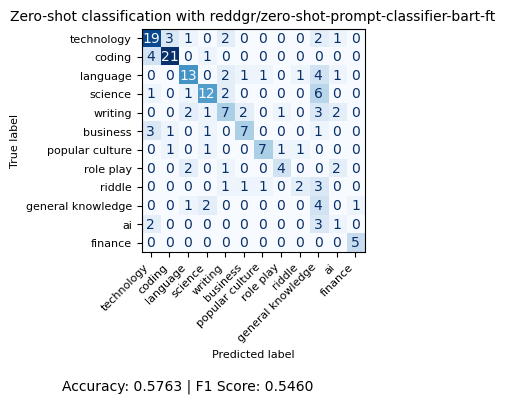

In [18]:
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
zs_test_metrics = zs_classifier.test_zs_predictions(test_entailments_df)

Zero-shot classification on test data:: 100%|██████████| 177/177 [08:43<00:00,  2.96s/it]


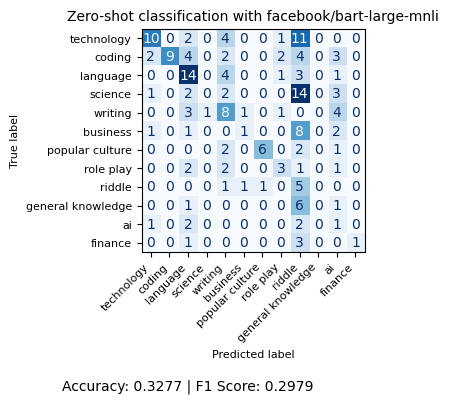

In [31]:
base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, nli_model_path, top_categories)
base_test_metrics = base_classifier.test_zs_predictions(test_entailments_df)

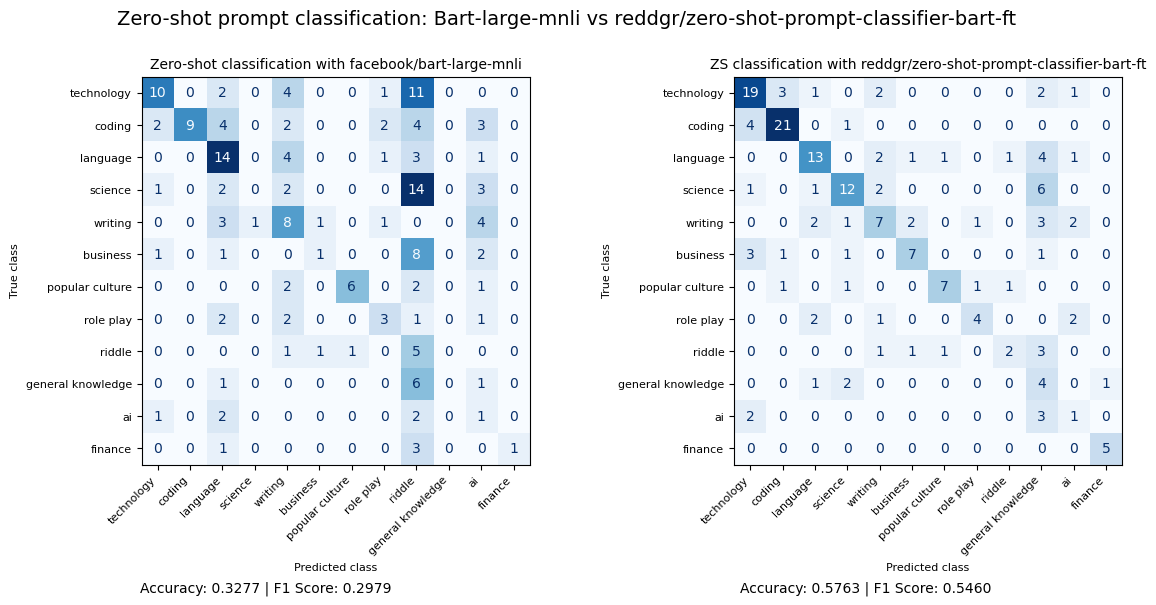

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Zero-shot prompt classification: Bart-large-mnli vs reddgr/zero-shot-prompt-classifier-bart-ft", fontsize=14)

# Plot for base_classifier (left)
disp1 = ConfusionMatrixDisplay(confusion_matrix=base_test_metrics["confusion_matrix"], display_labels=base_classifier.candidate_labels)
disp1.plot(cmap=plt.cm.Blues, ax=axes[0], colorbar=False)
axes[0].set_title(f"Zero-shot classification with {base_model_path}", fontsize=10)
axes[0].set_xlabel("Predicted class", fontsize=8)
axes[0].set_ylabel("True class", fontsize=8)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right", fontsize=8)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=8)

fig.text(
    0.25, 0.01, 
    f"Accuracy: {base_test_metrics['accuracy']:.4f} | F1 Score: {base_test_metrics['f1_score']:.4f}",
    ha="center",
    fontsize=10
)

# Plot for zs_classifier (fine-tuned) (right)
disp2 = ConfusionMatrixDisplay(confusion_matrix=zs_test_metrics["confusion_matrix"], display_labels=zs_classifier.candidate_labels)
disp2.plot(cmap=plt.cm.Blues, ax=axes[1], colorbar=False)
axes[1].set_title(f"ZS classification with {nli_model_path}", fontsize=10)
axes[1].set_xlabel("Predicted class", fontsize=8)
axes[1].set_ylabel("True class", fontsize=8)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right", fontsize=8)
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=8)

fig.text(
    0.75, 0.01, 
    f"Accuracy: {zs_test_metrics['accuracy']:.4f} | F1 Score: {zs_test_metrics['f1_score']:.4f}",
    ha="center",
    fontsize=10
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95]) 
plt.show()